In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import optuna

In [ ]:
# Load the dataset
# Make sure to adjust the path to your dataset accordingly
df = pd.read_csv('.csv')
df.head()

,week_date,total_sales,cost_iron,cost_aluminum,cost_energy,cost_production,fx_rate,ev_sales,export_values
0,28/12/2020,10932393.89,1.39,1645.84,0.0646,238.2905,1.2271,19852.25,409782999.8
1,4/1/2021,3686279.86,1.39,1645.84,0.0646,238.2905,1.2296,19852.25,409782999.8
2,11/1/2021,8965000.12,1.39,1645.84,0.0646,238.2905,1.2163,19852.25,409782999.8
3,18/01/2021,11766983.19,1.39,1645.84,0.0646,238.2905,1.2064,19852.25,409782999.8
4,25/01/2021,4926779.37,1.39,1645.84,0.0646,238.2905,1.2152,19852.25,409782999.8


In [3]:
# Convert 'week_date' to datetime format and set it as index
df['week_date'] = pd.to_datetime(df['week_date'], format='%d/%m/%Y')
df.set_index('week_date', inplace=True)

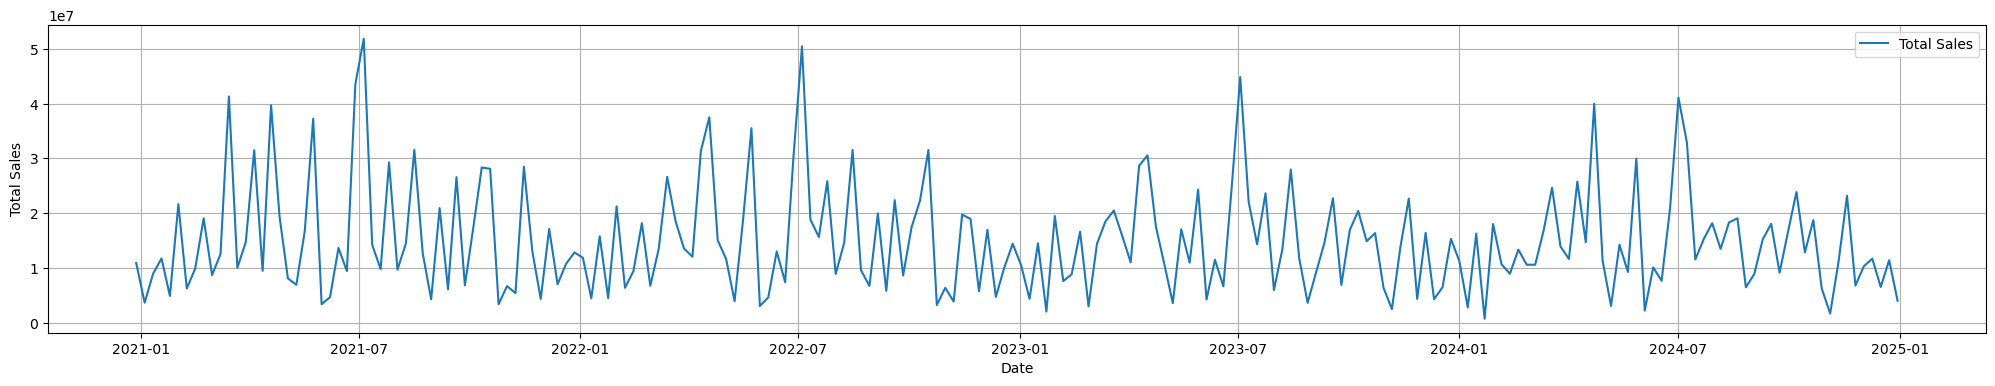

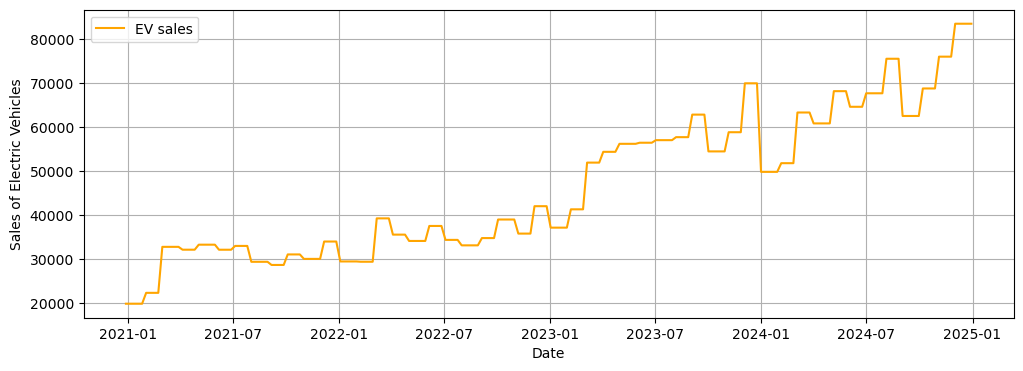

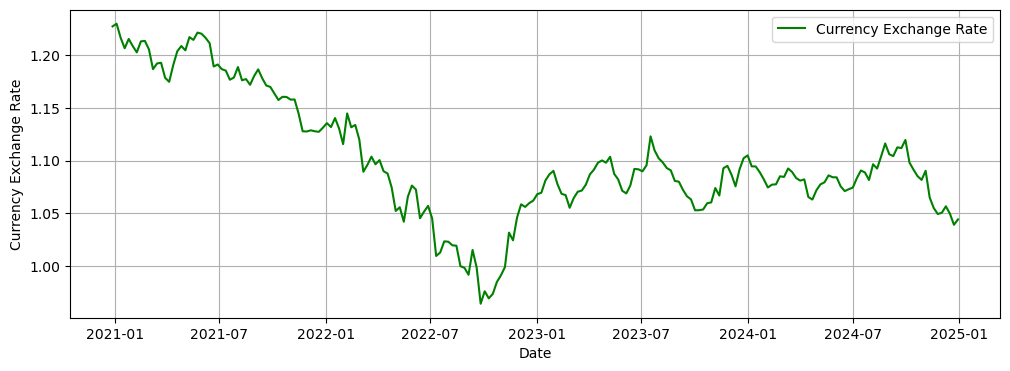

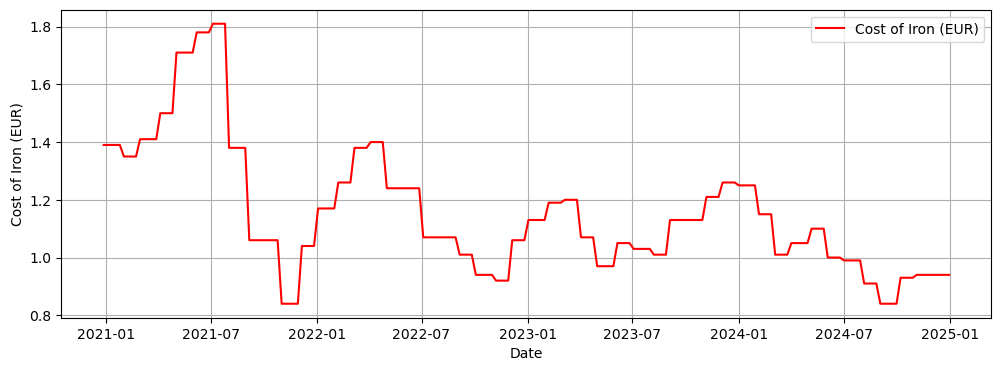

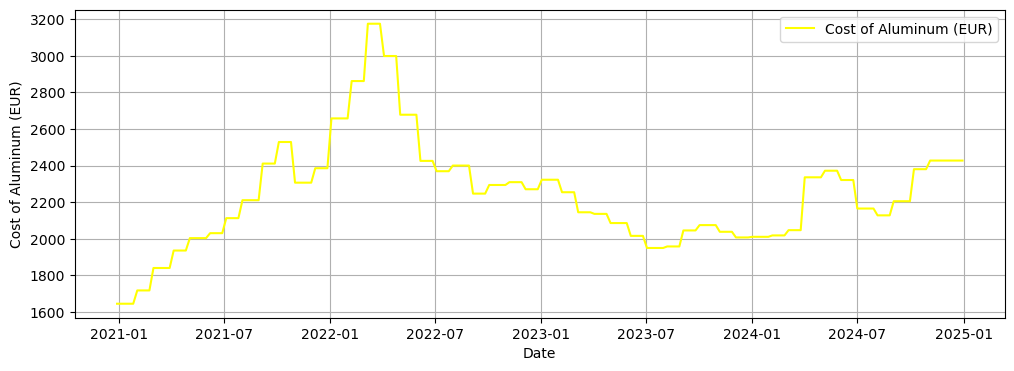

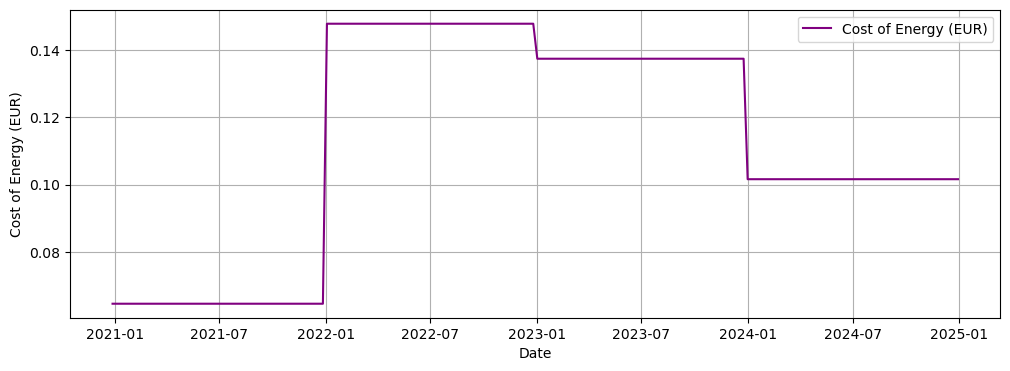

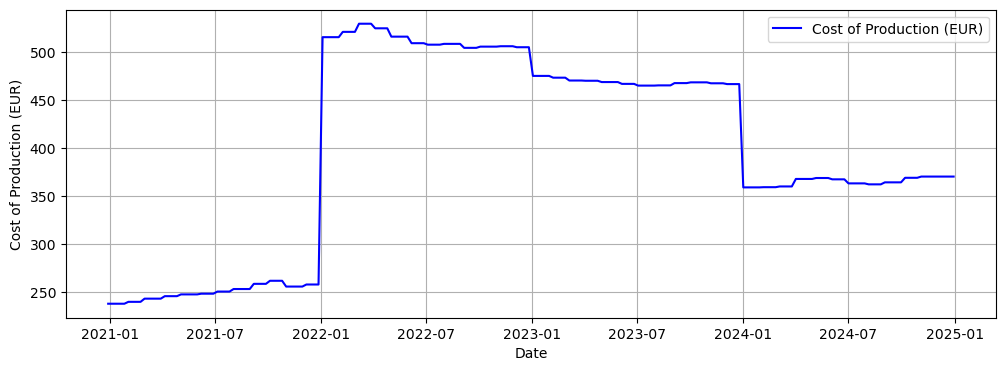

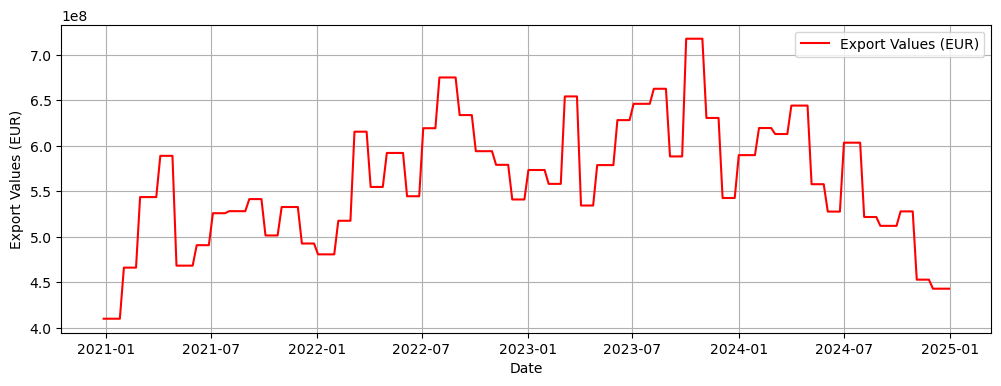

In [4]:
# Plotting variables to visualize
# Total Sales Plot
plt.figure(figsize=(25, 4))
plt.plot(df['total_sales'], label='Total Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

# EV Sales Plot
plt.figure(figsize=(12, 4))
plt.plot(df['ev_sales'], label=('EV sales'), color='orange')
plt.xlabel('Date')
plt.ylabel('Sales of Electric Vehicles')
plt.legend()
plt.grid(True)
plt.show()

# Currency Exchange Rate Plot
plt.figure(figsize=(12, 4))
plt.plot(df['fx_rate'], label='Currency Exchange Rate', color='green')
plt.xlabel('Date')
plt.ylabel('Currency Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Costs
plt.figure(figsize=(12, 4))
plt.plot(df['cost_iron'], label='Cost of Iron (EUR)', color='red')
plt.xlabel('Date')
plt.ylabel('Cost of Iron (EUR)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df['cost_aluminum'], label='Cost of Aluminum (EUR)', color='yellow')
plt.xlabel('Date')
plt.ylabel('Cost of Aluminum (EUR)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df['cost_energy'], label='Cost of Energy (EUR)', color='purple')
plt.xlabel('Date')
plt.ylabel('Cost of Energy (EUR)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df['cost_production'], label='Cost of Production (EUR)', color='blue')
plt.xlabel('Date')
plt.ylabel('Cost of Production (EUR)')
plt.legend()
plt.grid(True)
plt.show()

# Export Values Plot
plt.figure(figsize=(12, 4))
plt.plot(df['export_values'], label='Export Values (EUR)', color='red')
plt.xlabel('Date')
plt.ylabel('Export Values (EUR)')
plt.legend()
plt.grid(True)
plt.show()

# Stationary test

In [5]:
# Test stationarity of the target variable by the ADF test
result = adfuller(df['total_sales'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print("The series is stationary (reject H0).")
else:
    print("The series is non-stationary (fail to reject H0).")


ADF Statistic: -5.101288
p-value: 0.000014
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
The series is stationary (reject H0).


# Data preparation

Text(0.5, 1.0, 'Correlation Matrix')

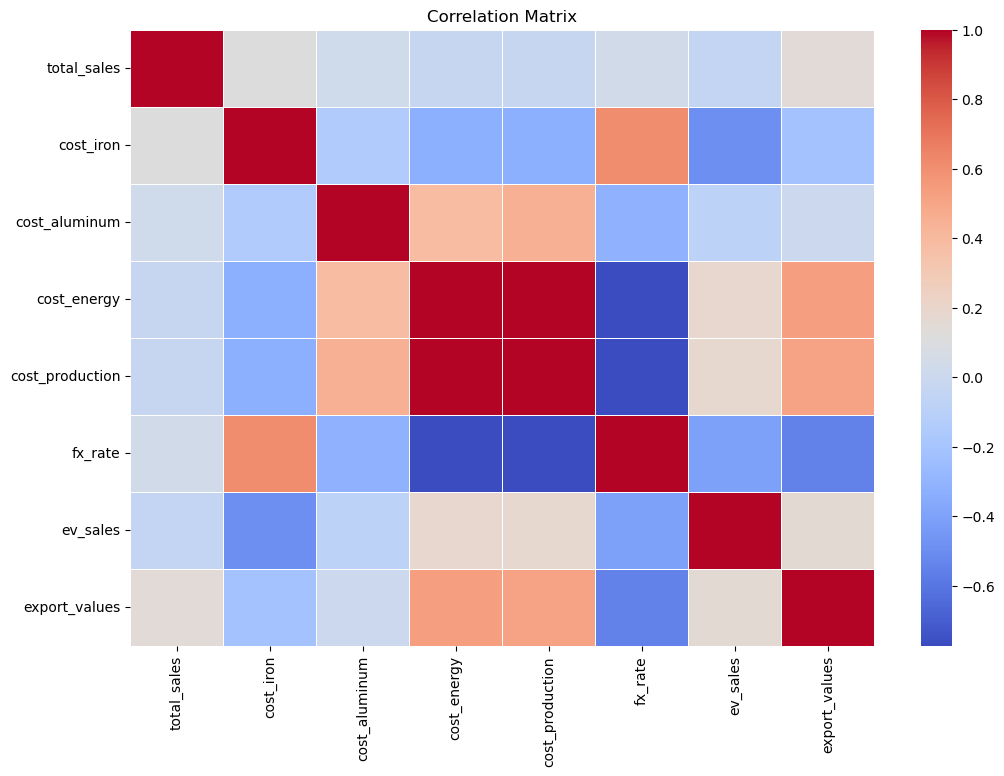

In [6]:
# Correlation matrix to check relationships between variables of the original dataset
correlation_matrix = df.corr()
correlation_matrix
# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')

In [7]:
# Creating new features (interaction terms) based on the variables that are correlated with each other
df['cost_iron_fx'] = df['cost_iron'] * df['fx_rate']
df['cost_aluminum_fx'] = df['cost_aluminum'] * df['fx_rate']
df['cost_production_fx'] = df['cost_production'] * df['fx_rate']
df['ev_sales_fx'] = df['ev_sales'] * df['fx_rate']

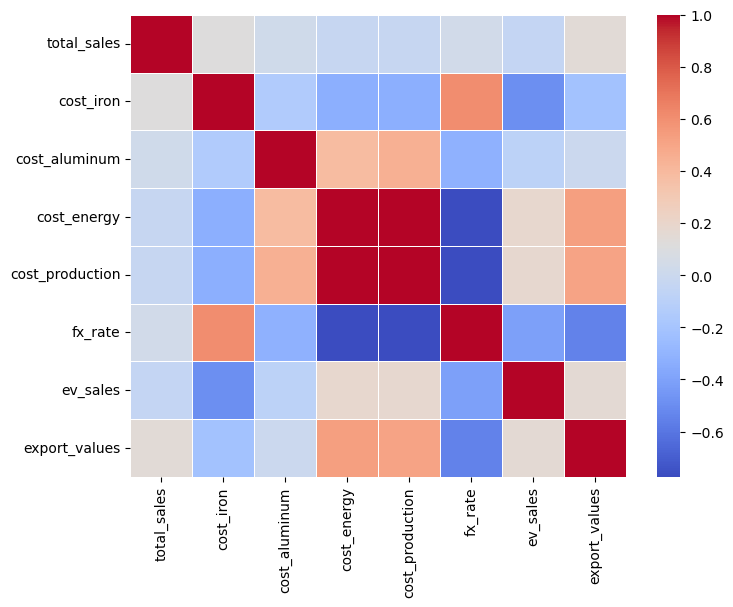

In [8]:
#  Calculating the correlation matrix after adding new interaction terms
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

# First baseline model

In [31]:
# Define the target variable and exogenous variables for the first ARIMAX model
target_col = 'total_sales'
exog_cols = [
    'cost_iron', 'cost_aluminum', 'cost_production', 'fx_rate', 'ev_sales', 'export_values',
    'cost_iron_fx', 'cost_aluminum_fx', 'cost_production_fx', 'ev_sales_fx']

In [32]:
train_df = df.loc[:'2024-06-24']  # End train on 2024-06-24 (Monday)
test_df = df.loc['2024-07-01':]   # Start test from 2024-06-24, but forecast from 2024-07-01

In [33]:
# Fit ARIMAX model
model = ARIMA(train_df[target_col], exog=train_df[exog_cols], order=(20, 0, 3))
results = model.fit()

# Get forecast starting from test_df index
forecast = results.forecast(steps=len(test_df), exog=test_df[exog_cols])
forecast_index = test_df.index
forecast_series = pd.Series(forecast, index=forecast_index)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    y_true = np.where(y_true == 0, 1e-10, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_df[target_col], forecast_series)
print(f"MAPE: {mape:.2f}%")

c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


MAPE: 57.65%


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Second baseline model

In [12]:
train_df1 = df.loc[:'2024-06-24']  # End train on 2024-06-24 (Monday)
test_df1 = df.loc['2024-07-01':]   # Start test from 2024-06-24, but forecast from 2024-07-01

In [13]:
# Define the target variable and exogenous variables for the second ARIMAX model
target_col1 = 'total_sales'
exog_cols1 = 'cost_production'

In [14]:
# Fit ARIMAX model with a single exogenous variable
model1 = ARIMA(train_df1[target_col1], exog=train_df1[exog_cols1], order=(20, 0, 3))
results1 = model1.fit()

# Get forecast starting from test_df index
forecast1 = results1.forecast(steps=len(test_df1), exog=test_df1[exog_cols1])
forecast_index1 = test_df1.index
forecast_series1 = pd.Series(forecast1, index=forecast_index1)

# Calculate MAPE 
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    y_true = np.where(y_true == 0, 1e-10, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape1 = mean_absolute_percentage_error(test_df1[target_col1], forecast_series1)
print(f"MAPE: {mape1:.2f}%")

c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


MAPE: 74.27%


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Model with altered hyperparameters

In [15]:
train_df2 = df.loc[:'2024-06-24']  # End train on 2024-06-24 (Monday)
test_df2 = df.loc['2024-07-01':]   # Start test from 2024-06-24, but forecast from 2024-07-01

In [16]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    y_true = np.where(y_true == 0, 1e-10, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
# Define the objective function for Optuna - Using AIC as the optimization metric
# The result of the optimization will be the hyperparameters of the cost_production that result in the lowest AIC.
# Each run will sample different coefficients for the cost variables - Will return different coefficients for each run.
def objective(trial):
    # Define the search space for coefficients
    # Each trial will pick a different combination of these values.
    # These sampled values define one candidate for the coefficients.
    I_coef = trial.suggest_float("I_coef", -3*0.035, 3*0.035)
    A_coef = trial.suggest_float("A_coef",  -3*0.027, 3*0.027)
    E_coef = trial.suggest_float("E_coef",  -3*2928, 3*2928)

    # Construct c for train and test sets
    c_train = I_coef * train_df2['cost_iron'] + A_coef * train_df2['cost_aluminum'] + E_coef * train_df2['cost_energy']
    c_test = I_coef * test_df2['cost_iron'] + A_coef * test_df2['cost_aluminum'] + E_coef * test_df2['cost_energy']

    try:
        # Fit model on train
        model3 = ARIMA(train_df2['total_sales'], exog=c_train, order=(20, 0, 3))
        results3 = model3.fit()

        return results3.aic

    except Exception as e:
        # Return a high penalty if fitting fails
        return float('inf')

# Set up Optuna study to minimize AIC
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Show best coefficients and AIC
print("Best coefficients (min AIC):")
print(f"I_coef: {study.best_params['I_coef']}")
print(f"A_coef: {study.best_params['A_coef']}")
print(f"E_coef: {study.best_params['E_coef']}")
print(f"Lowest AIC: {study.best_value:.2f}")


[I 2025-06-25 19:47:36,826] A new study created in memory with name: no-name-6024dfa2-ae7f-4f9d-b79a-d5249b07e6d9
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2025-06-25 19:47:39,707

Best coefficients (min AIC):
I_coef: 0.10369653547213455
A_coef: -0.07820122493563314
E_coef: 1871.1673040532805
Lowest AIC: 6407.75


In [18]:
# Create the cost variable for train and test set using the best coefficients found by Optuna
# Fit this into ARIMAX model as the exogenous variable (This combination is the best one at this running point)
# Change the coefficients to the best ones found by Optuna according to the code above
c_train1 = -0.05724810325734796 * train_df2['cost_iron'] + 0.05369408367664077 * train_df2['cost_aluminum'] + -1219.0105012674944 * train_df2['cost_energy']
c_test1 = -0.05724810325734796 * test_df2['cost_iron'] + 0.05369408367664077 * test_df2['cost_aluminum'] + -1219.0105012674944 * test_df2['cost_energy']    

In [19]:
model4 = ARIMA(train_df2['total_sales'], exog=c_train1, order=(20, 0, 3))
results4 = model4.fit()

# Get forecast starting from test_df index
forecast4 = results4.forecast(steps=len(test_df2), exog=c_test1)
forecast_index4 = test_df2.index
forecast_series4 = pd.Series(forecast4, index=forecast_index4)

mape4 = mean_absolute_percentage_error(test_df2['total_sales'], forecast_series4)
print(f"MAPE (Objective function: AIC): {mape4:.2f}%")

model4 = ARIMA(train_df2['total_sales'], exog=c_train1, order=(20, 0, 3))
results4 = model4.fit()
forecast4 = results4.forecast(steps=len(test_df2), exog=c_test1)
forecast_index4 = test_df2.index
forecast_series4 = pd.Series(forecast4, index=forecast_index4)
mape4 = mean_absolute_percentage_error(test_df2['total_sales'], forecast_series4)

c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so 

MAPE (Objective function: AIC): 75.86%


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
# Define the objective function for Optuna - Using MAPE as the optimization metric
# The result of the optimization will be the hyperparameters of the cost_production that result in the lowest MAPE.
# Each run will sample different coefficients for the cost variables - Will return different coefficients for each run.
def objective(trial):
    I_coef1 = trial.suggest_float("I_coef", -3 * 0.035, 3 * 0.035)
    A_coef1 = trial.suggest_float("A_coef", -3 * 0.027, 3 * 0.027)
    E_coef1 = trial.suggest_float("E_coef", -3 * 2928, 3 * 2928)

    # Construct exogenous variable 'c'
    c_train2 = I_coef1 * train_df2['cost_iron'] + A_coef1 * train_df2['cost_aluminum'] + E_coef1 * train_df2['cost_energy']
    c_test2 = I_coef1 * test_df2['cost_iron'] + A_coef1 * test_df2['cost_aluminum'] + E_coef1 * test_df2['cost_energy']

    # Wrap as DataFrame
    exog_train = pd.DataFrame({'c': c_train2})
    exog_test = pd.DataFrame({'c': c_test2})

    try:
        model5 = ARIMA(train_df2['total_sales'], exog=exog_train, order=(20, 0, 3))
        results5 = model5.fit()
        forecast5 = results5.forecast(steps=len(test_df2), exog=exog_test)

        mape5 = mean_absolute_percentage_error(test_df2['total_sales'].values, forecast5.values)
        return mape5

    except Exception as e:
        return float('inf')
    
study1 = optuna.create_study(direction="minimize")
study1.optimize(objective, n_trials=50)

# Show best coefficients and MAPE

print("Best coefficients (min MAPE):")
print(f"I_coef: {study1.best_params['I_coef']}")
print(f"A_coef: {study1.best_params['A_coef']}")
print(f"E_coef: {study1.best_params['E_coef']}")
print(f"Lowest MAPE: {study1.best_value:.2f}")


[I 2025-06-25 19:49:48,615] A new study created in memory with name: no-name-f01e55b2-4dfa-4bf8-8a3d-1e662dd984f2
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2025-06-25 19:49:51,389

Best coefficients (min MAPE):
I_coef: 0.01768172470217924
A_coef: -0.0782206686633639
E_coef: -1350.8139720942506
Lowest MAPE: 73.39


In [21]:
# Create the cost variable for train and test set using the best coefficients found by Optuna
# Fit this into ARIMAX model as the exogenous variable
# Change the coefficients to the best ones found by Optuna according to the code above
c_train3 = 0.06432563511460432 * train_df2['cost_iron'] + -0.0482948852168355 * train_df2['cost_aluminum'] + -529.2842878400565 * train_df2['cost_energy']
c_test3 = 0.06432563511460432 * test_df2['cost_iron'] + -0.0482948852168355 * test_df2['cost_aluminum'] + -529.2842878400565 * test_df2['cost_energy']    

In [22]:
model6 = ARIMA(train_df2['total_sales'], exog=c_train3, order=(20, 0, 3))
results6 = model6.fit()

# Get forecast starting from test_df index
forecast6 = results6.forecast(steps=len(test_df2), exog=c_test3)
forecast_index6 = test_df2.index
forecast_series6 = pd.Series(forecast6, index=forecast_index6)

mape6 = mean_absolute_percentage_error(test_df2['total_sales'], forecast_series6)
print(f"MAPE (Objective function: MAPE): {mape6:.2f}%")

c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


MAPE (Objective function: MAPE): 73.04%


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Model with altered formula

In [23]:
# Using Grid Search to find the best formula for cost_production, which returns lowest MAPE or AIC

# Fixed material coefficients
I_coef = 0.035
A_coef = 0.027
E_coef = 2928

# Compute cost variables
I_train = I_coef * train_df2['cost_iron']
A_train = A_coef * train_df2['cost_aluminum']
E_train = E_coef * train_df2['cost_energy']

I_test = I_coef * test_df2['cost_iron']
A_test = A_coef * test_df2['cost_aluminum']
E_test = E_coef * test_df2['cost_energy']

# Prevent log(0)
eps = 1e-8

# Define transformations involving all 3 materials
formulas = {
    "I*A + E": lambda I, A, E: I * A + E,
    "I + A*E": lambda I, A, E: I + A * E,
    "I*E + A": lambda I, A, E: I * E + A,
    "I*A*E": lambda I, A, E: I * A * E,

    "log(I*A*E)": lambda I, A, E: np.log(I * A * E + eps),

    "log(I*A) + E": lambda I, A, E: np.log(I * A + eps) + E,
    "log(I*E) + A": lambda I, A, E: np.log(I * E + eps) + A,
    "log(A*E) + I": lambda I, A, E: np.log(A * E + eps) + I,

    "I + log(A*E)": lambda I, A, E: I + np.log(A * E + eps),
    "A + log(I*E)": lambda I, A, E: A + np.log(I * E + eps),
    "E + log(I*A)": lambda I, A, E: E + np.log(I * A + eps),

    "log(I) + A + E": lambda I, A, E: np.log(I + eps) + A + E,
    "I + log(A) + E": lambda I, A, E: I + np.log(A + eps) + E,
    "I + A + log(E)": lambda I, A, E: I + A + np.log(E + eps),

    "log(I) + log(A*E)": lambda I, A, E: np.log(I + eps) + np.log(A * E + eps),
    "log(A) + log(I*E)": lambda I, A, E: np.log(A + eps) + np.log(I * E + eps),
    "log(E) + log(I*A)": lambda I, A, E: np.log(E + eps) + np.log(I * A + eps),

    "log(I) + log(A) + log(E)": lambda I, A, E: np.log(I + eps) + np.log(A + eps) + np.log(E + eps),
}

# Store AIC and MAPE for each formula
results = {}

for name, formula in formulas.items():
    try:
        c_train = formula(I_train, A_train, E_train)
        c_test = formula(I_test, A_test, E_test)

        # Ensure exogenous inputs are 2D
        exog_train = pd.DataFrame({'c': c_train})
        exog_test = pd.DataFrame({'c': c_test})

        model7 = ARIMA(train_df2['total_sales'], exog=exog_train, order=(20, 0, 3))
        fit = model7.fit()
        forecast7 = fit.forecast(steps=len(test_df2), exog=exog_test)

        forecast_series7 = pd.Series(forecast7, index=test_df2.index)

        # Compute AIC and MAPE
        aic = fit.aic
        mape7 = mean_absolute_percentage_error(test_df2['total_sales'], forecast_series7)

        if not np.isnan(mape7):
            results[name] = {'AIC': aic, 'MAPE': mape7}
            print(f"{name}: AIC = {aic:.2f}, MAPE = {mape7:.4f}")
        else:
             print(f"{name} skipped due to NaN MAPE.")

        print(f"{name}: AIC = {aic:.2f}, MAPE = {mape7:.4f}")

    except Exception as e:
        results[name] = {'AIC': float('inf'), 'MAPE': float('inf')}
        print(f"{name} failed: {e}")


# Find best formula by AIC and MAPE
best_aic_formula = min(results.items(), key=lambda x: x[1]['AIC'])
best_mape_formula = min(results.items(), key=lambda x: x[1]['MAPE'])

print("\n✅ Best by AIC:")
print(f"{best_aic_formula[0]} — AIC: {best_aic_formula[1]['AIC']:.2f}")

print("\n✅ Best by MAPE:")
print(f"{best_mape_formula[0]} — MAPE: {best_mape_formula[1]['MAPE']:.4f}")


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so 

I*A + E: AIC = 6408.04, MAPE = 74.6008
I*A + E: AIC = 6408.04, MAPE = 74.6008


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


I + A*E: AIC = 6408.18, MAPE = 73.8906
I + A*E: AIC = 6408.18, MAPE = 73.8906


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


I*E + A: AIC = 6407.66, MAPE = 73.9468
I*E + A: AIC = 6407.66, MAPE = 73.9468


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


I*A*E: AIC = 6408.01, MAPE = 72.9107
I*A*E: AIC = 6408.01, MAPE = 72.9107


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


log(I*A*E): AIC = 6407.97, MAPE = 72.9297
log(I*A*E): AIC = 6407.97, MAPE = 72.9297


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


log(I*A) + E: AIC = 6408.10, MAPE = 74.4071
log(I*A) + E: AIC = 6408.10, MAPE = 74.4071


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


log(I*E) + A: AIC = 6407.66, MAPE = 75.5601
log(I*E) + A: AIC = 6407.66, MAPE = 75.5601


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


log(A*E) + I: AIC = 6408.09, MAPE = 73.4427
log(A*E) + I: AIC = 6408.09, MAPE = 73.4427


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


I + log(A*E): AIC = 6408.09, MAPE = 73.4427
I + log(A*E): AIC = 6408.09, MAPE = 73.4427


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


A + log(I*E): AIC = 6407.66, MAPE = 75.5601
A + log(I*E): AIC = 6407.66, MAPE = 75.5601


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


E + log(I*A): AIC = 6408.10, MAPE = 74.4071
E + log(I*A): AIC = 6408.10, MAPE = 74.4071


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


log(I) + A + E: AIC = 6407.91, MAPE = 74.2764
log(I) + A + E: AIC = 6407.91, MAPE = 74.2764


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


I + log(A) + E: AIC = 6408.07, MAPE = 74.4203
I + log(A) + E: AIC = 6408.07, MAPE = 74.4203


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


I + A + log(E): AIC = 6407.67, MAPE = 75.4438
I + A + log(E): AIC = 6407.67, MAPE = 75.4438


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


log(I) + log(A*E): AIC = 6407.97, MAPE = 72.9397
log(I) + log(A*E): AIC = 6407.97, MAPE = 72.9397


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


log(A) + log(I*E): AIC = 6407.96, MAPE = 72.9622
log(A) + log(I*E): AIC = 6407.96, MAPE = 72.9622


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


log(E) + log(I*A): AIC = 6407.97, MAPE = 72.9451
log(E) + log(I*A): AIC = 6407.97, MAPE = 72.9451
log(I) + log(A) + log(E): AIC = 6407.96, MAPE = 72.9636
log(I) + log(A) + log(E): AIC = 6407.96, MAPE = 72.9636

✅ Best by AIC:
log(I*E) + A — AIC: 6407.66

✅ Best by MAPE:
I*A*E — MAPE: 72.9107


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Create the formula for cost_production for train and test set using the best coefficients found by Grid Search - lowest AIC formula
# Fit this into ARIMAX model as the exogenous variable
c_train4 = np.log(0.038 * train_df2['cost_iron'] * 0.027 * train_df2['cost_aluminum']) + 2928 * train_df2['cost_energy']
c_test4 = np.log(0.038 * test_df2['cost_iron'] * 0.027 * test_df2['cost_aluminum']) + 2928 * test_df2['cost_energy']   

In [25]:
model8 = ARIMA(train_df2['total_sales'], exog=c_train4, order=(20, 0, 3))
results8 = model8.fit()

# Get forecast starting from test_df index
forecast8 = results8.forecast(steps=len(test_df2), exog=c_test4)
forecast_index8 = test_df2.index
forecast_series8 = pd.Series(forecast8, index=forecast_index8)

mape8 = mean_absolute_percentage_error(test_df2['total_sales'], forecast_series8)
print(f"MAPE (Objective function: AIC): {mape8:.2f}%")

c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


MAPE (Objective function: AIC): 74.24%


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
# Create the formula for cost_production for train and test set using the best coefficients found by Grid Search - lowest MAPE formula
# Fit this into ARIMAX model as the exogenous variable
c_train5 = 0.038 * train_df2['cost_iron'] * 0.027 * train_df2['cost_aluminum'] * 2928 * train_df2['cost_energy']
c_test5 = 0.038 * test_df2['cost_iron'] * 0.027 * test_df2['cost_aluminum'] * 2928 * test_df2['cost_energy']   

In [27]:
model9 = ARIMA(train_df2['total_sales'], exog=c_train5, order=(20, 0, 3))
results9 = model9.fit()

# Get forecast starting from test_df index
forecast9 = results9.forecast(steps=len(test_df2), exog=c_test5)
forecast_index9 = test_df2.index
forecast_series9 = pd.Series(forecast9, index=forecast_index9)

mape9 = mean_absolute_percentage_error(test_df2['total_sales'], forecast_series9)
print(f"MAPE (Objective function: MAPE): {mape9:.2f}%")

c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


MAPE (Objective function: MAPE): 72.93%


c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Evaluation

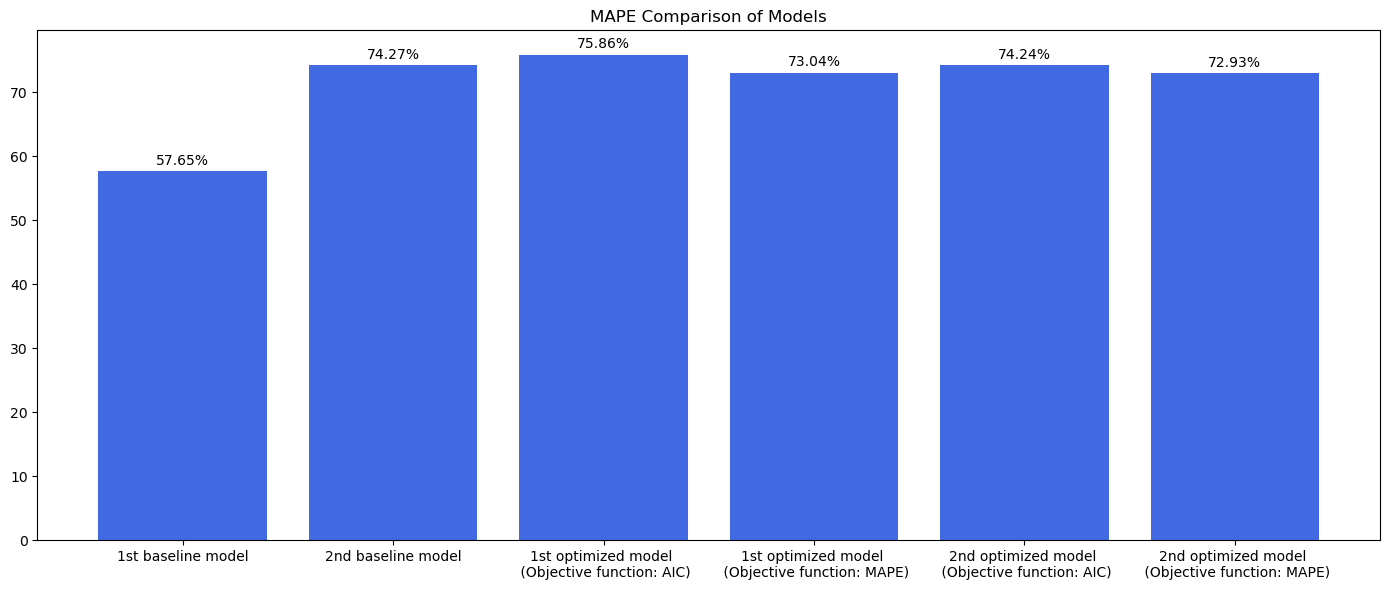

In [28]:
# Plotting MAPE values for all models
model_names = ['1st baseline model', '2nd baseline model', '1st optimized model \n (Objective function: AIC)', '1st optimized model \n (Objective function: MAPE)', '2nd optimized model \n (Objective function: AIC)', '2nd optimized model \n (Objective function: MAPE)']
mape_values = [mape, mape1, mape4, mape6, mape8, mape9]

plt.figure(figsize=(14, 6))
bars = plt.bar(model_names, mape_values, color='royalblue')
plt.title('MAPE Comparison of Models')

for bar, value in zip(bars, mape_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{value:.2f}%", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SLIM 7I\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so 

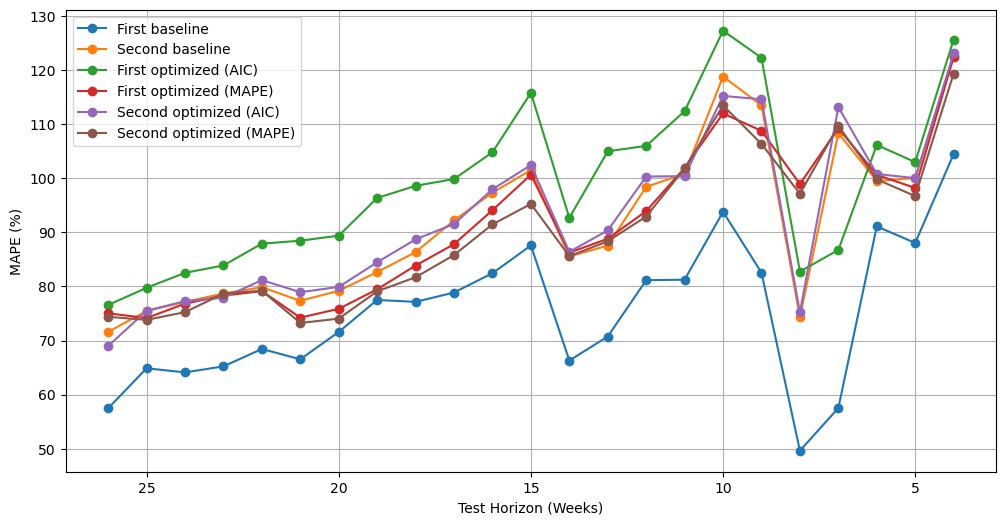

In [ ]:
# Testing the models with different test sizes

# MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = np.where(y_true == 0, 1e-10, y_true)  # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Weekly test sizes: from 26 weeks (6 months) to 4 weeks (1 month)
test_size = list(range(26, 3, -1))
model_mape = {
    'First baseline': [],
    'Second baseline': [],
    'First optimized (AIC)': [],
    'First optimized (MAPE)': [],
    'Second optimized (AIC)': [],
    'Second optimized (MAPE)': []
}

for weeks in test_size:
    train_df3 = df.iloc[:-weeks]
    test_df3 = df.iloc[-weeks:]

    if len(train_df3) < 50 or len(test_df3) < 4:
        continue

    try:
        # Fit ARIMAX model
        model = ARIMA(train_df3[target_col], exog=train_df3[exog_cols], order=(20, 0, 3))
        results = model.fit()
        forecast = results.forecast(steps=len(test_df3), exog=test_df3[exog_cols])
        forecast_series = pd.Series(forecast, index=test_df3.index)
        mape = mean_absolute_percentage_error(test_df3[target_col], forecast_series)
        model_mape['First baseline'].append(mape)
    except Exception as e:
        print(f"Error for {weeks} weeks: {e}")

    try:
        # Fit ARIMAX model with single exogenous variable
        model1 = ARIMA(train_df3[target_col1], exog=train_df3[exog_cols1], order=(20, 0, 3))
        results1 = model1.fit()
        forecast1 = results1.forecast(steps=len(test_df3), exog=test_df3[exog_cols1])
        forecast_series1 = pd.Series(forecast1, index=test_df3.index)
        mape1 = mean_absolute_percentage_error(test_df3[target_col1], forecast_series1)
        model_mape['Second baseline'].append(mape1)
    except Exception as e:
        print(f"Error for {weeks} weeks (single exog): {e}")

    try:
        # Fit ARIMAX model with cost variables optimized by AIC
        c_train6 = (
            -0.05724810325734796 * train_df3['cost_iron'] +
            0.05369408367664077 * train_df3['cost_aluminum'] +
            -1219.0105012674944 * train_df3['cost_energy']
        )
        c_test6 = (
            -0.05724810325734796 * test_df3['cost_iron'] +
            0.05369408367664077 * test_df3['cost_aluminum'] +
            -1219.0105012674944 * test_df3['cost_energy']
        )
        model4 = ARIMA(train_df3['total_sales'], exog=c_train6, order=(20, 0, 3))
        results4 = model4.fit()
        forecast4 = results4.forecast(steps=len(test_df3), exog=c_test6)
        forecast_series4 = pd.Series(forecast4, index=test_df3.index)
        mape4 = mean_absolute_percentage_error(test_df3['total_sales'], forecast_series4)
        model_mape['First optimized (AIC)'].append( mape4)
    except Exception as e:
        print(f"Error for {weeks} weeks (AIC): {e}")

    try:
        # Fit ARIMAX model with cost variables optimized by MAPE
        c_train7 = (
            0.06432563511460432 * train_df3['cost_iron'] +
            -0.0482948852168355 * train_df3['cost_aluminum'] +
            -529.2842878400565 * train_df3['cost_energy']
        )
        c_test7 = (
            0.06432563511460432 * test_df3['cost_iron'] +
            -0.0482948852168355 * test_df3['cost_aluminum'] +
            -529.2842878400565 * test_df3['cost_energy']
        )
        model6 = ARIMA(train_df3['total_sales'], exog=c_train7, order=(20, 0, 3))
        results6 = model6.fit()
        forecast6 = results6.forecast(steps=len(test_df3), exog=c_test7)
        forecast_series6 = pd.Series(forecast6, index=test_df3.index)
        mape6 = mean_absolute_percentage_error(test_df3['total_sales'], forecast_series6)
        model_mape['First optimized (MAPE)'].append(mape6)
    except Exception as e:
        print(f"Error for {weeks} weeks (MAPE): {e}")

    try:
        # Fit ARIMAX model with cost variables optimized by AIC
        c_train8 = np.log(0.038 * train_df3['cost_iron'] * 0.027 * train_df3['cost_aluminum']) + 2928 * train_df3['cost_energy']
        c_test8 = np.log(0.038 * test_df3['cost_iron'] * 0.027 * test_df3['cost_aluminum']) + 2928 * test_df3['cost_energy']
        model8 = ARIMA(train_df3['total_sales'], exog=c_train8, order=(20, 0, 3))
        results8 = model8.fit()
        forecast8 = results8.forecast(steps=len(test_df3), exog=c_test8)
        forecast_series8 = pd.Series(forecast8, index=test_df3.index)
        mape8 = mean_absolute_percentage_error(test_df3['total_sales'], forecast_series8)
        model_mape['Second optimized (AIC)'].append(mape8)
    except Exception as e:
        print(f"Error for {weeks} weeks (AIC second): {e}")

    try:
        # Fit ARIMAX model with cost variables optimized by MAPE
        c_train9 = 0.038 * train_df3['cost_iron'] * 0.027 * train_df3['cost_aluminum'] * 2928 * train_df3['cost_energy']
        c_test9 = 0.038 * test_df3['cost_iron'] * 0.027 * test_df3['cost_aluminum'] * 2928 * test_df3['cost_energy']
        model9 = ARIMA(train_df3['total_sales'], exog=c_train9, order=(20, 0, 3))
        results9 = model9.fit()
        forecast9 = results9.forecast(steps=len(test_df3), exog=c_test9)
        forecast_series9 = pd.Series(forecast9, index=test_df3.index)
        mape9 = mean_absolute_percentage_error(test_df3['total_sales'], forecast_series9)
        model_mape['Second optimized (MAPE)'].append(mape9)
    except Exception as e:
        print(f"Error for {weeks} weeks (MAPE second): {e}")

plt.figure(figsize=(12, 6))
for model_name, mape_values in model_mape.items():
    plt.plot(test_size[:len(mape_values)], mape_values, marker='o', label=model_name)

plt.gca().invert_xaxis()
plt.xlabel('Test Horizon (Weeks)')
plt.ylabel('MAPE (%)')
plt.legend()
plt.grid(True)
plt.show()


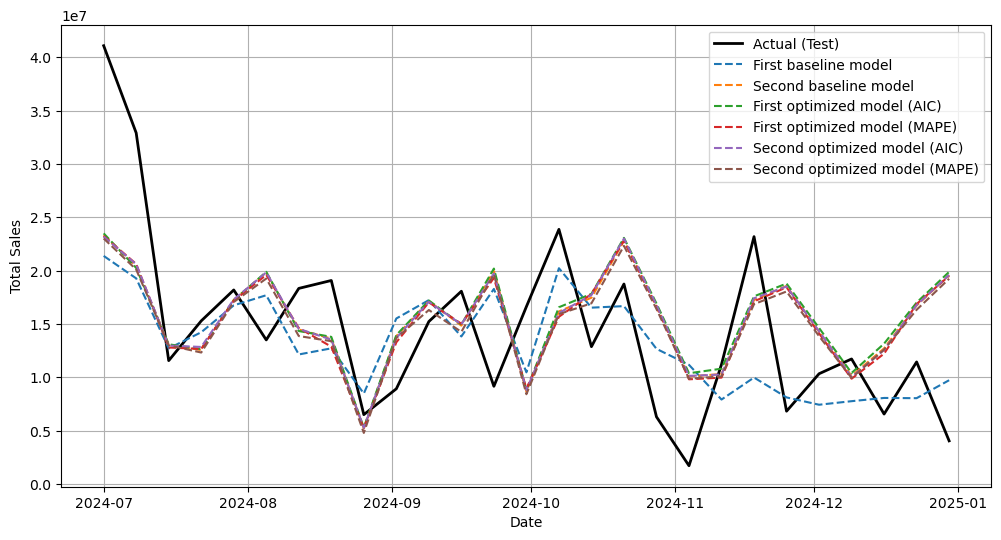

In [ ]:
# Plotting all forecast series on the same graph for comparison

plt.figure(figsize=(12, 6))

# Actual test values
plt.plot(test_df2.index, test_df2['total_sales'], label='Actual (Test)', color='black', linewidth=2)

# All forecast series
plt.plot(forecast_series.index, forecast_series, label='First baseline model', linestyle='--')
plt.plot(forecast_series1.index, forecast_series1, label='Second baseline model', linestyle='--')
plt.plot(forecast_series4.index, forecast_series4, label='First optimized model (AIC)', linestyle='--')
plt.plot(forecast_series6.index, forecast_series6, label='First optimized model (MAPE)', linestyle='--')
plt.plot(forecast_series8.index, forecast_series8, label='Second optimized model (AIC)', linestyle='--')
plt.plot(forecast_series9.index, forecast_series9, label='Second optimized model (MAPE)', linestyle='--')

# Labels
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()
